# CISC 452 Assignment 2 - Backpropagation (100 points)  

Please put your name and student id

    FirstName LastName, #12345678

- The notebook file has clearly marked blocks where you are expected to write code. Do not write or modify any code outside of these blocks.
- Do not add or delete cells from the notebook.
- Run all cells, and do not clear out the outputs, before submitting. You will only get credit for code that has been run.
- Make sure to run all the cells from beginning before the submission

## [Part 1 (60 points)](#Part-1)  

### Build Model1 (50 points)  
Use Pytorch to implement a three-layer Neural Network (input layer - hidden layer - output layer) and update the weights with backpropagation  
- 1. Implement forward and calculate the output (10 points)  
- 2. Calculate errors and loss (10 points)  
- 3. Update the weights with backpropagation (20 points)  
- 4. Predict function (5 points)  
- 5. Activation function (Sigmoid function) (5 points)  

### Evaluate Model1 (10 points)  
Use the predict function to predict the labels with the test dataset (5 points)  
Evaluate the prediction results (5 points)   
- Evaluation matrices include confusion matrix, accuracy, recall score, precision and F1 score

## [Part 2 (40 points)](#Part-2)  

Use another machine learning framework (**scikit-learn, Tensorflow and Pytorch**) to build MLP
e.g. 
  1. https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
  2. https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
  3. https://pytorch.org/tutorials/beginner/examples_nn/polynomial_nn.html#sphx-glr-beginner-examples-nn-polynomial-nn-py
  
### Build Model2-1 (15 points)  
Implement model 2-1 with the same hidden nodes and optimization function as the model in Part 1  
Train and validate model. Use the best model on validation dataset to test on the test dataset  

### Evaluate Model2-1 (5 points)
Evaluate the prediction results (5 points)   
- Evaluation matrices include confusion matrix, accuracy, recall score, precision and F1 score

### Build Model2-2 (15 points)  
Add one more hidden layer (2 hidden layers in total) to the model  
Describe Model 2-2 (number of hidden nodes)  
Train and validate model. Use the best model on validation dataset to test on the test dataset  

### Evaluate Model2-2 (5 points)
Evaluate the prediction results (5 points)   
- Evaluation matrices include confusion matrix, accuracy, recall score, precision and F1 score

In [42]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.neural_network import MLPClassifier

In [43]:
# make sure you are using GPU, or you can go to Edit - Notebook settings to select under the Hardware accelerator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [44]:
# build the dataset (train, validation and test)

def load_MNIST(n_val=10000, n_sample=1000, sample=False):
    n_val = n_val
    n_sample = n_sample
    train = MNIST(root = '.', train = True, download = True)
    test = MNIST(root = '.', train = False, download = True)
    
    # data preprocessing
    x_train, x_test = train.data/255, test.data/255
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    y_train = torch.nn.functional.one_hot(train.targets)
    y_test = torch.nn.functional.one_hot(test.targets)

    data_dict = {}
    if sample:
        data_dict['x_train'] = x_train[:-n_val][:n_sample]
        data_dict['y_train'] = y_train[:-n_val][:n_sample]
        data_dict['x_val'] = x_train[-n_val:][:n_sample//10]
        data_dict['y_val'] = y_train[-n_val:][:n_sample//10]
        data_dict['x_test'] = x_test[:n_sample//10]
        data_dict['y_test'] = y_test[:n_sample//10]
    else:
        data_dict['x_train'] = x_train[:-n_val]
        data_dict['y_train'] = y_train[:-n_val]
        data_dict['x_val'] = x_train[-n_val:]
        data_dict['y_val'] = y_train[-n_val:]
        data_dict['x_test'] = x_test
        data_dict['y_test'] = y_test
    return data_dict

In [45]:
# you can start with a small sample dataset by setting sample=True
data_dict = load_MNIST(sample=False)
print('Train data shape:', data_dict['x_train'].shape)
print('Train labels shape:', data_dict['y_train'].shape)
print('Validation data shape:', data_dict['x_val'].shape)
print('Validation labels shape:', data_dict['y_val'].shape)
print('Test data shape:', data_dict['x_test'].shape)
print('Test labels shape:', data_dict['y_test'].shape)

Train data shape: torch.Size([50000, 784])
Train labels shape: torch.Size([50000, 10])
Validation data shape: torch.Size([10000, 784])
Validation labels shape: torch.Size([10000, 10])
Test data shape: torch.Size([10000, 784])
Test labels shape: torch.Size([10000, 10])


In [46]:
# check the data distribution if you use a sample dataset to avoid imbanlance dataset
for i in range(10):
    print(torch.sum(torch.argmax(data_dict['y_test'], dim=1)==i))

tensor(980)
tensor(1135)
tensor(1032)
tensor(1010)
tensor(982)
tensor(892)
tensor(958)
tensor(1028)
tensor(974)
tensor(1009)


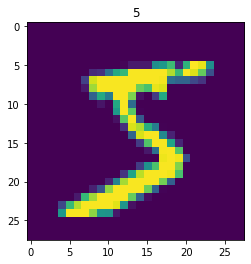

In [47]:
# plot an example
plt.imshow(data_dict['x_train'][0].reshape(28, 28))
plt.title(data_dict['y_train'][0].argmax().item())
plt.show()

In [48]:
# TODO: use the predict function to predict the lables with the test dataset
# TODO: evaluate the prediction results (accuracy, recall score, precision and F1 score)
####################################################################################################
# enter code here to calculate the hidden layer output and output layer output
# Write a function to analyze the result
def evaluator(test_y, pred_y):
  confusion_matr = confusion_matrix(test_y, pred_y)
  accu = accuracy_score(test_y, pred_y)
  reca = recall_score(test_y, pred_y, average='macro')
  prec = precision_score(test_y, pred_y, average='macro')
  F1 = (2*prec*reca)/(prec+reca)
  print(confusion_matr)
  print('accuracy %.4f, precise %.4f, recall %.4f, F1 score %.4f' %(accu ,prec, reca, F1))


####################################################################################################

## Part 1

In [49]:
class NN(object):
    def __init__(self, hidden_size, device, dtype=torch.float32):
        self.hidden_size = hidden_size
        self.device = device
        self.dtype = dtype
        self.history = {}
        self.history['train_acc'], self.history['val_acc'], self.history['loss'] = [], [], []
        
    def sigmoid(self, x):
        ####################################################################################################
        # 5. enter code here to implement the activation function
        fx = torch.sigmoid(x)     
        return fx
        ####################################################################################################

    def train(self, x, y, x_val, y_val, learning_rate=0.001, n_iters=100, batch_size=200, verbose=0):
        n_train = x.shape[0]
        n_val = x_val.shape[0]
        input_size = x.shape[1]
        num_classes = y.shape[1]
        
        self.params = {}
        ####################################################################################################
        # You can change the initialzation here if you want
        self.W1 = torch.randn(input_size, self.hidden_size, dtype=self.dtype, device=self.device) * 0.01
        self.b1 = torch.zeros(self.hidden_size, dtype=self.dtype, device=self.device)
        self.W2 = torch.randn(self.hidden_size, num_classes, dtype=self.dtype, device=self.device) * 0.01
        self.b2 = torch.zeros(num_classes, dtype=self.dtype, device=self.device)
        ####################################################################################################


        # TODO: train the weights with the input data and labels
        for i in range(n_iters):
            loss = 0
            data = getBatch(x, y, batch_size)
            for x_batch, y_batch in data:
                # forward
                ####################################################################################################
                # 1. enter code here to calculate the hidden layer output and output layer output
                
                output1 = self.sigmoid(torch.matmul(x_batch, self.W1) + self.b1)
                
                output2 = self.sigmoid(torch.matmul(output1, self.W2) + self.b2)
                ####################################################################################################

                ####################################################################################################
                # 2. enter code here to calculate the hidden layer error, output layer error and loss
                # (dj – 𝒚𝒋)
                output_error = y_batch - output2

                # 𝒚𝒋.(1 – 𝒚𝒋)
                omyj = output2 * (1 - output2)

                # (dj – 𝒚𝒋). 𝒚𝒋.(1 – 𝒚𝒋)
                delta = omyj * output_error

                hidden_error = torch.matmul(delta, self.W2.T)
                
                # loss
                loss += torch.mean(torch.square(output_error))
                
                
                ####################################################################################################
              

                # backward
                ####################################################################################################
                # 3. enter code here to update the weights with the errors
                # 𝒚𝒉.(1 – 𝒚𝒉)
                omyh = output1 *(1 - output1)               
                
                dwp1 = omyh * hidden_error
                    
                dw1 = learning_rate*torch.matmul(dwp1.T, x_batch)

                dw2 = learning_rate*torch.matmul(delta.T,output1)                              
                


                self.W1 += dw1.T

                self.W2 += dw2.T

                self.b1 += learning_rate * torch.sum(dwp1, 0)

                self.b2 += learning_rate * torch.sum(delta, 0)

                ####################################################################################################

            # calculate the accuracy
            y_pred = self.predict(x)
            train_acc = torch.sum(torch.argmax(y, dim=1) == torch.argmax(y_pred, dim=1)) / n_train
            self.history['train_acc'].append(train_acc)
            self.history['loss'].append(loss)
            
            y_pred = self.predict(x_val)
            val_acc = torch.sum(torch.argmax(y_val, dim=1) == torch.argmax(y_pred, dim=1)) / n_val
            self.history['val_acc'].append(val_acc)
            if verbose:
                print('epoch %d, loss %.4f, train acc %.3f, validation acc %.3f'
                  % (i + 1, loss, train_acc, val_acc))
                
    def predict(self, x):
        ####################################################################################################
        # 4. enter code here to complete the predict function
        # TODO: use the trained weights to predict labels and return the predicted labels
        hidden_output = self.sigmoid(torch.matmul(x, self.W1) + self.b1)
        y_pred = self.sigmoid(torch.matmul(hidden_output, self.W2) + self.b2)
        ####################################################################################################
        return y_pred

def getBatch(x, y, batch_size):
    n_epoch = x.shape[0] // batch_size
    for i in range(n_epoch):
        x_batch = x[i * batch_size : (i+1) * batch_size]
        y_batch = y[i * batch_size : (i+1) * batch_size]
        yield x_batch, y_batch
    x_batch = x[(i+1) * batch_size:]
    y_batch = y[(i+1) * batch_size:]    
    yield x_batch, y_batch

In [50]:
####################################################################################################
# enter code here to tune the parameters
# TODO: set your desired hidden size, learning rate, number of iterations and batch size
hidden_size = 100

model = NN(hidden_size, device)
model.train(data_dict['x_train'].to(device),
            data_dict['y_train'].to(device),
            data_dict['x_val'].to(device),
            data_dict['y_val'].to(device), 
            learning_rate=0.01,
            n_iters=10,
            batch_size=32,
            verbose=1)
####################################################################################################

epoch 1, loss 108.8805, train acc 0.816, validation acc 0.835
epoch 2, loss 43.7811, train acc 0.891, validation acc 0.903
epoch 3, loss 30.3699, train acc 0.905, validation acc 0.916
epoch 4, loss 25.9106, train acc 0.914, validation acc 0.923
epoch 5, loss 23.3882, train acc 0.920, validation acc 0.928
epoch 6, loss 21.6216, train acc 0.926, validation acc 0.932
epoch 7, loss 20.2449, train acc 0.930, validation acc 0.936
epoch 8, loss 19.1024, train acc 0.933, validation acc 0.939
epoch 9, loss 18.1184, train acc 0.936, validation acc 0.942
epoch 10, loss 17.2528, train acc 0.939, validation acc 0.945


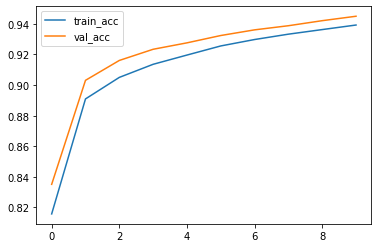

In [51]:
plt.plot(model.history['train_acc'], label='train_acc')
plt.plot(model.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [52]:
y_pred = model.predict(data_dict['x_test'].to(device))
evaluator(data_dict['y_test'].argmax(dim=1), torch.argmax(y_pred, dim=1).cpu())

[[ 961    0    0    1    0    2   11    1    4    0]
 [   0 1110    3    3    0    2    4    2   11    0]
 [   9    0  956    8   10    2   13   14   18    2]
 [   0    0   18  944    1   18    3   11   12    3]
 [   1    3    4    0  920    1   11    2    7   33]
 [   8    3    2   25    5  805   17    2   16    9]
 [   9    3    4    0    6   12  920    1    3    0]
 [   3    8   23    3    7    1    0  963    2   18]
 [   5    4    3   14    7   11   10    9  907    4]
 [  11    7    1   12   27   10    1   11    4  925]]
accuracy 0.9411, precise 0.9404, recall 0.9404, F1 score 0.9404


## Part 2

### Model2-1

In [53]:
####################################################################################################
# enter code here to implement evaluate Model2-1
# I tried to use 'sgd' solver, but seems 'adam' performs better
from sklearn.neural_network import MLPClassifier
X_train, X_test, y_train, y_test = data_dict['x_train'].to(device), data_dict['x_test'].to(device), data_dict['y_train'].to(device), data_dict['y_test'].to(device)
clf = MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', batch_size=200, max_iter=100, verbose=False, early_stopping=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred = torch.from_numpy(y_pred)
evaluator(data_dict['y_test'].argmax(dim=1), torch.argmax(y_pred, dim=1).cpu())
####################################################################################################

[[ 974    0    1    0    0    1    3    1    0    0]
 [  10 1115    4    0    0    1    4    1    0    0]
 [  38    1  981    0    2    0    3    5    2    0]
 [  33    0    4  962    0    3    0    3    4    1]
 [  24    0    3    0  943    0    4    0    0    8]
 [  44    1    0   10    0  826    3    2    5    1]
 [  22    2    1    0    4    5  924    0    0    0]
 [  30    1    8    2    0    0    0  981    0    6]
 [  46    0    4    3    4    5    2    4  904    2]
 [  43    3    0    4   13    2    0    5    1  938]]
accuracy 0.9548, precise 0.9602, recall 0.9542, F1 score 0.9572


### Model2-2

In [54]:
####################################################################################################
# enter code here to implement evaluate Model2-2
'''
Since our data is not very large, 2 hidden layers may be enough. The optimal layer nodes need trials, so after several simple tests, 150 for the first hidden layer and 
100 for the second layer shows the best performance.
'''
from sklearn.neural_network import MLPClassifier
X_train, X_test, y_train, y_test = data_dict['x_train'].to(device), data_dict['x_test'].to(device), data_dict['y_train'].to(device), data_dict['y_test'].to(device)
clf = MLPClassifier(hidden_layer_sizes=(150, 100,), activation='logistic', batch_size=200, max_iter=100, verbose=False, early_stopping=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred = torch.from_numpy(y_pred)
evaluator(data_dict['y_test'].argmax(dim=1), torch.argmax(y_pred, dim=1).cpu())
####################################################################################################

[[ 975    0    0    0    0    1    2    1    1    0]
 [   8 1120    2    0    0    1    1    0    3    0]
 [  18    1 1005    0    1    0    0    4    3    0]
 [  14    0    7  983    0    1    0    3    1    1]
 [   9    0    1    0  960    0    4    1    1    6]
 [  22    0    0    6    1  857    2    0    3    1]
 [  15    3    2    0    4    3  927    0    4    0]
 [  15    2    6    1    2    0    0  997    0    5]
 [  21    0    5    4    2    4    0    2  935    1]
 [  23    3    0    6    7    2    0    5    1  962]]
accuracy 0.9721, precise 0.9734, recall 0.9718, F1 score 0.9726
